In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
from matplotlib import patches, lines

%matplotlib inline

In [49]:
colors = pickle.load(open('../../../figures/colors.p', 'rb'))

In [24]:
case_counts = pd.read_csv('../../../data/frequencies/reich2013_case_counts.csv', index_col=0)
case_counts.head()

serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']

case_counts = pd.read_csv('../../../data/frequencies/reich2013_case_counts.csv', index_col=0)
case_counts.rename(columns={ 'den.cases.str%d'%d : 'DENV%d'%d for d in range(1,5)}, inplace=True)
case_counts = case_counts[serotypes + ['date']]

def bin_date(date):
    year, month, day = map(int, date.split('-'))
    if 1<=month<=3:
        month = 0.1667
    elif 4<=month<=6:
        month = 0.41667
    elif 7<=month<=9:
        month = 0.6667
    else:
        month = 0.91667    
    return year + month

case_counts['date'] = case_counts['date'].map(bin_date)
case_counts = case_counts.groupby('date').agg(sum)
case_counts.pivot_table(index='date')
case_counts = case_counts.astype(float)
case_counts.index = case_counts.index.map(lambda d: round(d,2))
case_counts.index.name = None

def normalize_timepoint(row):
    total = row.sum()
    
    if not np.isnan(total) and total > 0:
        return row.map(lambda x: x / total)
    else:
        return row
    
case_counts = case_counts.apply(normalize_timepoint, axis=1)

print case_counts.tail()

            DENV1     DENV2     DENV3     DENV4
2009.92  0.330827  0.353383  0.285714  0.030075
2010.17  0.205882  0.362745  0.392157  0.039216
2010.42  0.261905  0.547619  0.166667  0.023810
2010.67  0.364780  0.446541  0.144654  0.044025
2010.92  0.367347  0.295918  0.285714  0.051020


In [25]:
frequencies = pd.read_csv('../../../data/frequencies/thai_serotype_frequencies.csv', index_col=0)
frequencies.index = frequencies.index.map(lambda d: round(d,2))
frequencies = frequencies.loc[(1975. <= frequencies.index) & (frequencies.index <= 2011) ]
case_counts = case_counts.loc[(1975. <= case_counts.index) & (case_counts.index <= 2011) ]

In [26]:
print frequencies.tail()
print case_counts.tail()

            DENV1     DENV2     DENV3     DENV4
2009.92  0.410775  0.356104  0.204465  0.028656
2010.17  0.212556  0.469927  0.232831  0.084686
2010.42  0.137820  0.252008  0.415273  0.194899
2010.67  0.107094  0.161413  0.533377  0.198116
2010.92  0.096720  0.161774  0.500890  0.240616
            DENV1     DENV2     DENV3     DENV4
2009.92  0.330827  0.353383  0.285714  0.030075
2010.17  0.205882  0.362745  0.392157  0.039216
2010.42  0.261905  0.547619  0.166667  0.023810
2010.67  0.364780  0.446541  0.144654  0.044025
2010.92  0.367347  0.295918  0.285714  0.051020


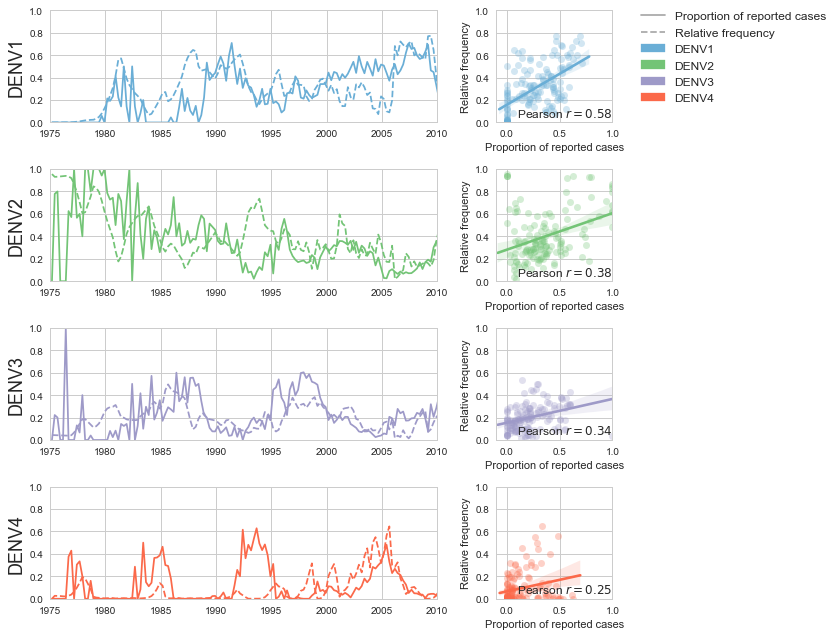

In [100]:
def make_scatterplot(case_counts, frequencies, serotype, ax, c):
    counts, freqs = case_counts[serotype], frequencies[serotype]
    sns.regplot(case_counts[serotype], frequencies[serotype], ax=ax, scatter_kws={'alpha': 0.3}, color=c)
    fit = scipy.stats.linregress(counts.values, freqs.values)
    r = fit[2]
    ax.text(1, 0.05, r'Pearson $r = %.2f$'%r, ha='right', transform=ax.transAxes)
    ax.set_xlabel('Proportion of reported cases')
    ax.set_ylabel('Relative frequency')
    ax.set_xlim(-0.1,1)
    ax.set_ylim(0,1)
    
def compare_timeseries(case_counts, frequencies, serotype, ax, c):
    ax.plot(frequencies.index.values, frequencies[serotype], c=c, linestyle='--', label='Frequency of sequenced isolates')
    ax.plot(case_counts.index.values, case_counts[serotype], c=c, linestyle='-', label='Proportion of reported cases')    
    ax.set_ylabel(serotype, fontdict={'fontsize': 18})
    ax.set_ylim(0,1)
    ax.set_xlim(1975,2010)

sns.set(style='whitegrid', font_scale=1.0)
fig, ax_array = plt.subplots(ncols=2, nrows=4, figsize=(9,9),gridspec_kw={'width_ratios': [1,0.3]})

for serotype, axes in zip(serotypes, ax_array):
    make_scatterplot(case_counts, frequencies, serotype, axes[1], c=colors[serotype])
    compare_timeseries(case_counts, frequencies, serotype, axes[0], c = colors[serotype])


legend_handles = [ lines.Line2D([], [], color='darkgray', linestyle='-',label='Proportion of reported cases'),
                  lines.Line2D([], [], color='darkgray', linestyle='--',label='Relative frequency')]
legend_labels = ['Proportion of reported cases', 'Relative frequency']

for s in serotypes:
    legend_patch = patches.Patch( color=colors[s], label=s)
    legend_handles.append(legend_patch)
    legend_labels.append(s)

fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.3,0.99),
           bbox_transform=plt.gcf().transFigure, prop={'size': 12})

plt.tight_layout()
plt.savefig('../../../figures/png/thai_frequencies_comparison.png', dpi=300, bbox_inches='tight')
plt.show()